In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep as fallasleep
import os, sys

In [2]:
from src.colortools import color_box

# Import data from Kraken 
source: [https://www.kraken.com/]

In [3]:
import krakenex
from pykrakenapi import KrakenAPI

### Choice of coins
- Ethereum: smart contract that is powering lots of Dapps.
- BTC:      still has the crown of all crypto.
- XRP:      fastest transaction speed, that has the most potential being used within the financial institutions.
- ADA:      Cardano uses third-generation proof-of-state with a strong focus on sustainability, scalability, and transparency.
- DOT:      polkadot is a multichain network that aims to be the central network that connects to other network protocols.

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD      0
BTCUSD      0
XRPUSD      0
ADAUSD      0
DOTUSD    267
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD    0
BTCUSD    0
XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-18,422.62,11957.0,0.30292,0.137218,3.1099
2020-08-19,407.57,11757.4,0.28992,0.129678,2.9175
2020-08-20,416.20,11864.6,0.29246,0.134305,2.9090


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-19,-0.036261,-0.016834,-0.043864,-0.056516,-0.063863
2020-08-20,0.020953,0.009076,0.008723,0.035059,-0.002918
2020-08-21,-0.070599,-0.029240,-0.046364,-0.087043,0.056341


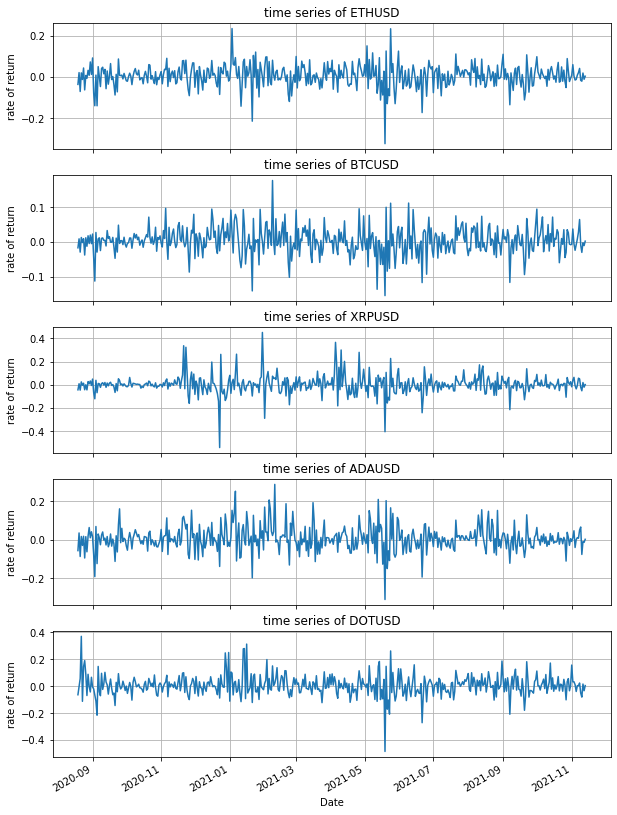

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

##### Mean-Variance Portfolio Optimization (cardinality constraint, no short selling)
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & (\textit{risk factor}) \times \frac{1}{2} x^TQx - r^Tx\\
& \text{subject to} && \mathbf{1}^Tx=k\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [11]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [12]:
from gurobipy import *

In [13]:
def obj_val(x):
    return 0.5 * lam * (x @ Q @ x) - (r @ x)

def print_bold(string, end=False):
    if end:
        print('\033[91m' + '\033[1m' + string + '\033[0m',end="")
    else:
        
        print('\033[91m' + '\033[1m' + string + '\033[0m')

In [36]:
m   = Model("MVO")
x   = {}
n   = len(Q)
lam = 0.5
k   = 2
x   = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = lam * 0.5 * (x @ Q @ x) - (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
gurobi   = []
for v in m.getVars():
    gurobi.append(int(v.x))
    if v.x == 1:
        selected.append(v.VarName)
print(f"Gurobi selected:         {selected}")
print(f"Gurobi optimal solution: {gurobi}")
print(f"Gurobi optimal value:    {obj_val(gurobi)}")

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x1c27cd68
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 6e-03]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0070744
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -8.632935e-03, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00863    0    4   -0.00707   -0.00863  22.0%     -    0s
H    0     0                      -0

## Using Qiskit

In [19]:
from qiskit                                   import Aer
from qiskit.algorithms                        import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers             import COBYLA
from qiskit.circuit.library                   import TwoLocal
from qiskit.utils                             import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms           import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit_optimization.converters           import QuadraticProgramToQubo
from qiskit.utils                             import algorithm_globals

##### Mean-Variance Optimization (with cardinality constraint, no short selling), QUBO - hold / not hold
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & (\textit{risk factor}) \times \frac{1}{2} x^TQx - r^Tx +  P \cdot (\mathbf{1}^Tx - k)^2\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [33]:
portfolio = PortfolioOptimization(expected_returns=r, covariances=0.5*Q,
                                  risk_factor=lam, budget=n)
qp = portfolio.to_quadratic_program()
num_qubits = n
seed = 6969

### QAOA

In [21]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.6f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        if (x == gurobi).all():
            print_bold('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        else:
            print('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [31]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, 
                                   seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3,
                quantum_instance=quantum_instance)
exact_mes = NumPyMinimumEigensolver()

qaoa = MinimumEigenOptimizer(qaoa_mes)
exact = MinimumEigenOptimizer(exact_mes)
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=2**num_qubits, 
                                       min_num_vars_optimizer=exact)
result = rqaoa.solve(qp)
print(result)
# selection, state, values, probabilities = print_result(result)
selection = result.x


print(f"QAOA selected:         {selection_to_picks(n, selection)}")
print(f"QAOA solution: {selection}")
print(f"QAOA value:    {obj_val(selection)}")

optimal function value: -0.00827551429666246
optimal value: [1. 0. 0. 1. 0.]
status: SUCCESS
QAOA selected:         ['ETHUSD', 'ADAUSD']
QAOA solution: [1. 0. 0. 1. 0.]
QAOA value:    -0.00827551429666246


### VQE

In [25]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
ry = TwoLocal(n, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

selection, state, values, probabilities = print_result(result)
print(f"VQE selected:          {selection_to_picks(n, selection)}")
print(f"VQE solution:  {selection}")
print(f"VQE value:     {obj_val(selection)}")

Optimal: selection [0. 1. 0. 0. 1.], value -0.002002

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.001934		0.676059
[0 0 0 1 1]	-0.001860		0.300452
[0 1 0 0 1]	-0.002002		0.017667
[0 0 1 0 1]	0.000171		0.005694
[0 1 1 0 1]	1.029598		0.000036
[0 1 0 1 1]	1.027490		0.000024
[0 1 1 1 1]	4.118701		0.000017
[1 1 1 0 1]	4.118538		0.000012
[1 0 1 1 1]	4.119607		0.000011
[1 1 0 0 1]	1.027479		0.000009
[0 0 0 0 1]	1.027634		0.000007
[1 1 0 1 1]	4.116397		0.000005
[1 0 0 1 1]	1.027999		0.000003
[1 1 1 1 1]	9.267067		0.000001
[1 0 1 0 0]	-0.000516		0.000000
[1 1 0 0 0]	-0.002552		0.000000
[0 0 1 1 0]	-0.000357		0.000000
[0 1 0 1 0]	-0.002608		0.000000
[1 0 1 0 1]	1.030063		0.000000
[0 0 1 1 1]	1.030289		0.000000
[1 0 0 1 0]	-0.002619		0.000000
[1 1 1 0 0]	1.028801		0.000000
[0 0 1 0 0]	1.029271		0.000000
[0 0 0 1 0]	1.027201		0.000000
[1 0 0 0 0]	1.027193		0.000000
[1 0 1 1 0]	1.029282		0.000000

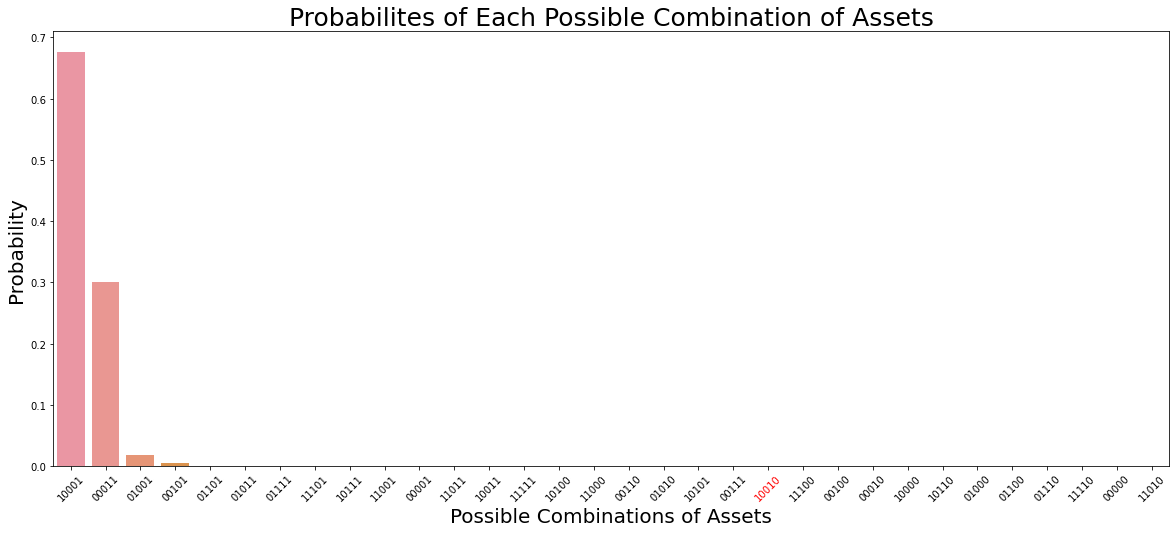

In [26]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=state, y=probabilities)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

In [88]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info  import Statevector

In [139]:
from mpl_toolkits import mplot3d
import binascii

In [149]:
def get_qaoa_circuit(n,J,h, beta, gamma, measure=True):
    qc = QuantumCircuit(n)

    for i in range(n):
        # super position all states
        qc.h(i)

    for i in range(n):
        # rotate i along the x axis by beta
        qc.rx(2 * beta*h[i], i)

    for i in range(n-1):
        qc.rz(2 * gamma * J[i][i], i)
        for j in range(i+1,n):
            # first, add CNOT gate from i to j
            # second, rotate j along the z axis by gamma
            # finally, add another CNOT gate from i to j
            qc.rzz(2 * gamma * J[i][j], i, j)
        qc.barrier()
    if measure:
        # measure the state for each i
        qc.measure_all()

    return qc

def get_expected_loss(counts):
    expected_loss = 0
    total_count = sum(counts.values())
    for state in counts:
        freq      = counts[state]
        state     = [int(s) for s in state]
        obj_value = obj_val(state)
        prob      = freq / total_count
        expected_loss += prob*obj_value
    return expected_loss

In [150]:
%matplotlib inline

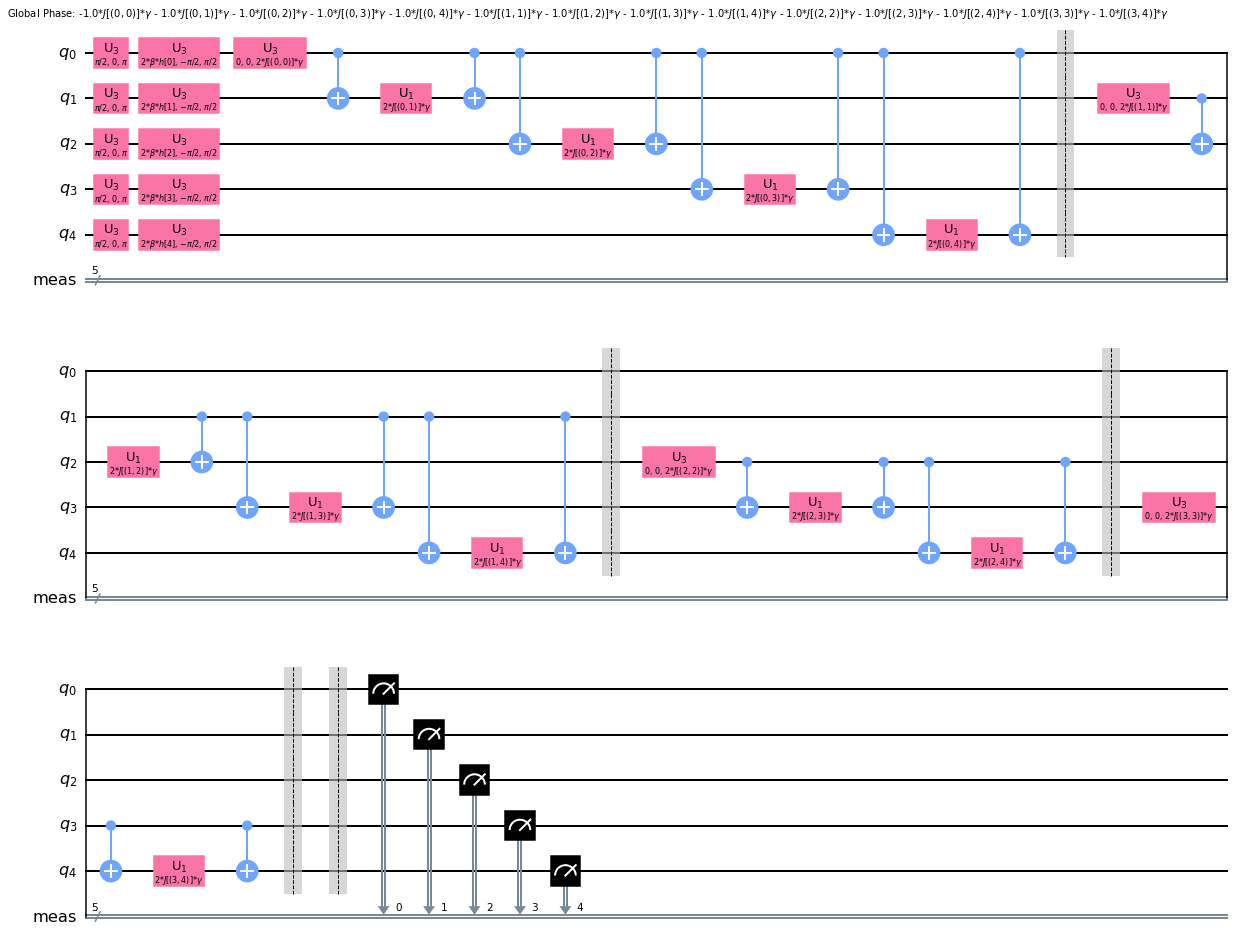

In [151]:
beta  = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")
J = [[Parameter(f"$J[{i,j}]$") for j in range(n)] for i in range(n)]
h = [Parameter(f"$h[{i}]$") for i in range(n)]
qaoa_qc = get_qaoa_circuit(n,J,h, beta, gamma)
qaoa_qc.decompose().decompose().draw(output='mpl')

### Circuit Design

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL

let $\textit{risk factor} = \lambda$, then we have our QUBO formulation for our problem
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{\lambda}{2} x^TQx - r^Tx +  P \cdot (\mathbf{1}^Tx - k)^2\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P = \mathbb{E}[r^Tx - \frac{\lambda}{2}x^TQx]$

The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbf{1} \mathbf{1}^T \right] x + \left[-r - 2Pk\mathbf{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

where $C=k^2P$.

#### Corresponding Ising Model

define a new variable $s$ such that $x = \frac{1-s}{2}$, so $s \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{s}{\text{minimize}} & & s^T \left[\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbf{1}\mathbf{1}^T\right)\right]s
+ \frac{1}{2}\left[r + 2kP\mathbf{1} -(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T) \right]^Ts
+ C\\
        &&& s \in \{-1,1\}\\
\end{aligned}
$$

where $C=k^2P - \frac{1}{2}(r+2kP\mathbb{1})^T\mathbb{1} + 1^T\left[\frac{1}{4}(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T)\right]^T\mathbb{1}$.

#### Corresponding Hamiltonian
let $J =\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbf{1}\mathbf{1}^T\right)$, and let $h = \frac{1}{2}\left[r + 2kP\mathbf{1} -(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T) \right]$.

We have $U(\gamma,C)=e^{\sum_{i=1}^n \sum_{j=1}^n -\frac{i\pi\gamma}{2} J_{ij}s_i s_j \sum_{i=1}^n-\frac{i\pi \gamma h_i}{2}s_i}$ $\quad$ or $\quad$ $U(\gamma,C)=\prod_{ij}e^{-\frac{i\pi\gamma}{2} J_{ij}s_i s_j} \prod_{i}e^{-\frac{i\pi \gamma }{2}h_i s_i}$

AND

$U(\beta,B)=e^{\frac{i\pi \beta}{2}B}$, where $B=\sum_{i=1}^n \sigma_x^i$ $\quad$ or $\quad$ $U(\beta,B)=\prod_{i=1}^n e^{\frac{i\pi \beta}{2}\sigma_x^i}$

In [160]:
# P = -np.sum(Q) / (2 * n**2) * k**2 * lam + k * (1 - lam) / n * np.sum(r)
# P *= 5
P = -lam*np.min(Q)*k**2 + k*np.max(r)

J = 1/4 * (lam*Q + P*np.ones((n,n)))
h = 1/2 * (r + 2*k*P*np.ones(n) - np.ones(n).dot((lam*Q + P*np.ones((n,n)))))
C = k**2*P - 1/2*(r + 2*k*P*np.ones(n)).dot(np.ones(n)) + np.ones(n).dot(1/4*(lam*Q+P*np.ones((n,n)))).dot(np.ones(n))


scalar = 500
J *= scalar
h *= scalar
C *= scalar

# J = J.astype(int)
# h = h.astype(int)

In [161]:
def get_qaoa_circuit(n,J,h, beta_list, gamma_list, p=1):
    
    qc = QuantumCircuit(n)

    for i in range(n):
        # super position all states
        qc.h(i)
    start = 0
    while start < p:
        beta  = beta_list[start]
        gamma = gamma_list[start]
        for i in range(n):
            # rotate i along the x axis by beta
            qc.rx(beta*h[i], i)

        for i in range(n-1):
            qc.rz(2 * gamma * J[i][i], i)
            for j in range(i+1,n):
                # first, add CNOT gate from i to j
                # second, rotate j along the z axis by gamma
                # finally, add another CNOT gate from i to j
                qc.rzz(2 * gamma * J[i][j], i, j)
            qc.barrier()
        start += 1
        
    # measure the state for each i
    qc.measure_all()

    return qc

def get_expected_loss(counts):
    expected_loss = 0
    total_count = sum(counts.values())
    for state in counts:
        freq      = counts[state]
        state     = [int(s) for s in state]
        obj_value = obj_val(state)
        prob      = freq / total_count
        expected_loss += prob*obj_value
    return expected_loss

### Try grid search to find a good guess for the parameter pair $\beta$ and $\gamma$ with dept $p=1$

In [162]:
loss_dim = 20
expected_loss = np.zeros((loss_dim,loss_dim))
dept = 1
for _b, beta in enumerate(np.arange(0,1,1/loss_dim)):
    for _g, gamma in enumerate(np.arange(0,2,2/loss_dim)):
        start = 0
        beta *= np.pi
        gamma *= np.pi
        beta_list = [beta] * dept
        gamma_list = [gamma] * dept
        qaoa_qc = get_qaoa_circuit(n,J,h,beta_list,gamma_list,p=dept)
        backend = Aer.get_backend("statevector_simulator")
        job     = execute(qaoa_qc, backend, shots = 10000)
        result  = job.result()
        counts  = result.get_counts()
        opt_sol = max(counts, key=counts.get)
        opt_sol = [int(s) for s in opt_sol]
        expected_loss[_b][_g] = obj_val(opt_sol)

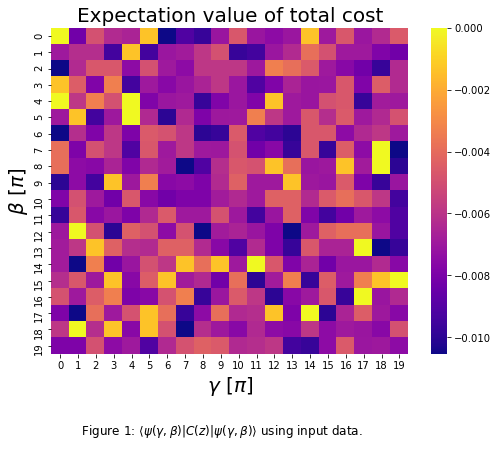

In [163]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(expected_loss, cbar=True,cmap='plasma')
ax.set_title('Expectation value of total cost',size=20)
ax.set_xlabel(r'$\gamma \ [\pi]$',size=20)
ax.set_ylabel(r'$\beta \ [\pi]$',size=20)
text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(1)
plt.text(0,26, text, ha='left', size=12)
plt.show()

In [164]:
X = np.pi*np.arange(0,1,1/loss_dim)
Y = np.pi*np.arange(0,2,2/loss_dim)
X = np.arange(0,loss_dim)
Y = X.copy()
X,Y = np.meshgrid(X,Y)
print(X.shape, Y.shape, expected_loss.shape)

(20, 20) (20, 20) (20, 20)


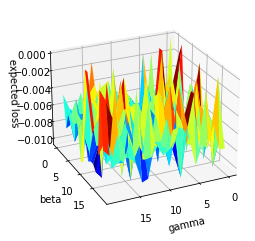

In [165]:
fit=plt.figure()
ax =plt.axes(projection='3d')
ax.plot_surface(X, Y, (expected_loss), rstride=1, cstride=1,
                cmap='jet', edgecolor='None')
ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('expected loss')
ax.view_init(25, 65)
# ax.set_zlim([np.min(expected_loss)*1.5, np.max(expected_loss)])

plt.show()

In [166]:
dept = 10
_b,_g = np.unravel_index(expected_loss.argmin(), expected_loss.shape)
beta, gamma = [_b/20]*dept, [_g/20] * dept
qaoa_qc = get_qaoa_circuit(n,J,h,beta,gamma,p=dept)

backend = Aer.get_backend("statevector_simulator")
job     = execute(qaoa_qc, backend, shots = 10000)
result  = job.result()
counts  = result.get_counts()
counts  ={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}

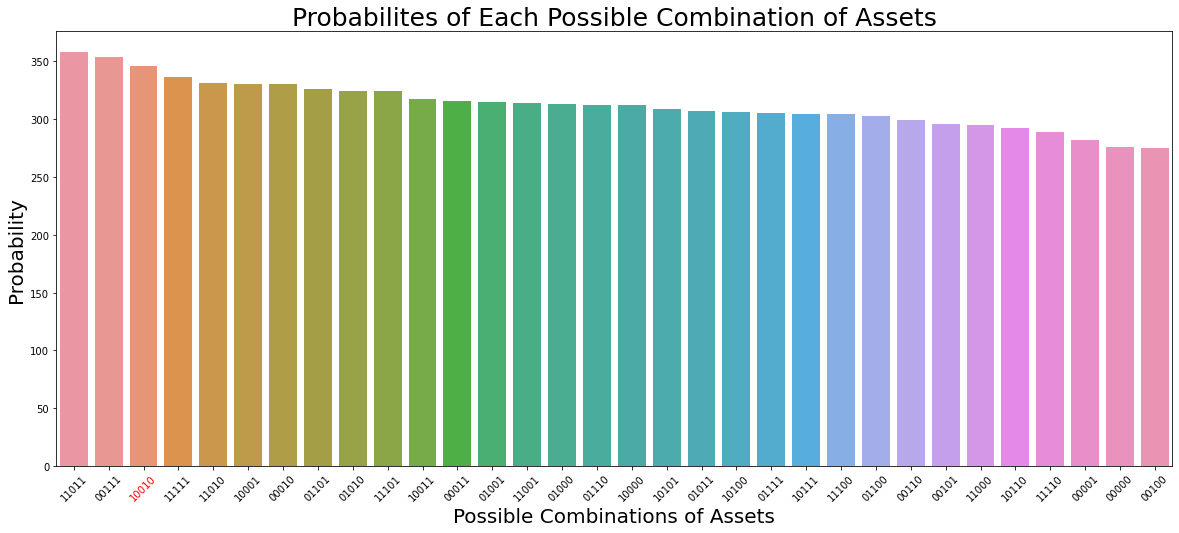

In [167]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=list(counts.keys()), y=list(counts.values()))
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.get_xticklabels()
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### Grid search is usable for a shorter circuits, but for p > 5, this is very expansive to use. We use gradient decent-based method to find the optimal parameter pairs $\beta$ and $\gamma$.

In [121]:

def optimize_circuit_GD(circuit,J,h,n_trials,p,lr=0.2,steps=10):
    '''
    Gradient descent optimization
    '''
    
    backend = Aer.get_backend("statevector_simulator")
    # Initialize random gradients
    E_gradients = np.random.rand(2*p)
    x = np.random.rand(2*p)
    dx = np.zeros(2 * p)

    for k in tqdm(range(steps)):

       # Compute the energy
        #E = self.circuit_measurement_function(x,circuit,parameters,n_trials=n_trials,p=p)

        for i in range(len(x)):
            dx[:] = 0.0
            dx[i] = lr * E_gradients[i]
            #TODO find the gradient of the expected value with respect to beta and gamma
            job     = execute(qaoa_qc, backend, shots = 10000)
            result  = job.result()
            
            E_pdx = circuit_measurement_function(x + dx, circuit, parameters, n_trials=n_trials, p=p)
            

            E_mdx = circuit_measurement_function(x - dx, circuit, parameters, n_trials=n_trials, p=p)
            E_gradients[i] = 0.5*((E_pdx-E_mdx)/np.sqrt(np.sum(dx**2)))

        #update the parameters
        x = x-lr*E_gradients
        #x = np.array([x[i]+2.0*np.pi if x[i] < 0.0 else x[i]-2.0*np.pi if x[i] > 2.0*np.pi else x[i] for i in range(len(x))])

    # get the other results
    gammas = x[0:p]
    betas = x[p:]
    bitstrings = self.measure_circuit(circuit, parameters=parameters, betas=betas, gammas=gammas, n_trials=n_trials)
    portfolio_holdings = self.convert_bitstrings_to_portfolio_holdings(bitstrings)
    energy_expectation_value = self.compute_total_cost_expectation_value(portfolio_holdings, parameters)
    best_solutions = self.determine_best_solution_from_trials(parameters, portfolio_holdings)

    results={}
    results['portfolio_holdings'] = portfolio_holdings
    results['best_solutions'] = best_solutions
    results['optimal_gammas'] = gammas
    results['optimal_betas'] =  betas
    results['optimal_energy_measurement'] = energy_expectation_value

    return results

In [111]:
loss_dim = 20
expected_loss = np.zeros((loss_dim,loss_dim))
p = 6
for _b, beta in enumerate(np.arange(0,2,2/loss_dim)):
    for _g, gamma in enumerate(np.arange(0,2,2/loss_dim)):
        start = 0
        beta *= np.pi/2
        gamma *= np.pi
        qaoa_qc = get_qaoa_circuit(n,J,h,beta,gamma,p=p)
        backend = Aer.get_backend("statevector_simulator")
        job     = execute(qaoa_qc, backend, shots = 10000)
        result  = job.result()
        counts  = result.get_counts()
        counts={k: v for k, v in sorted(counts.items(),
                                        key=lambda item: item[1],
                                        reverse=True)}
#         expected_loss[_b][_g] = get_expected_loss(counts)

In [ ]:

beta, gamma = _b/20, _g/20
# qaoa_qc = get_qaoa_circuit(n, , np.pi*beta/2, np.pi*gamma)
# qaoa_qc.decompose().decompose().draw(output='mpl')

backend = Aer.get_backend("statevector_simulator")
job     = execute(qaoa_qc, backend, shots = 10000)
result  = job.result()
counts  = result.get_counts()
counts={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}
expected_loss[_b][_g] = get_expected_loss(counts)

##### Minimum Variance Portfolio Optimization (without cardinality constraint, no short selling)
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} x^TQx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &&& \lambda \in [0,1]\\
\end{aligned}
$$